# Searching for digit manifolds

In this notebook, we'll calculate the level of agreement between elements of a class of digits. The intention is to use the similarity of class elements to sort the elements into a manifold (each successive element appears to be a slight perturbation or continuous deformation of the previous element).

There are 10 classes of digits 0-9. Let $A$ and $B$ be elements of class $N$. For current purposes, the level of agreement between $A$ and $B$ is given by

$$
    \frac{||A\odot B||_F}{\sqrt{||A\odot A||_F}\sqrt{||B\odot B||_F}},
$$
where $\odot$ represents the element-wise Hadamard product, and $||\cdot||_F$ is the Frobenius norm.

I've tried norms of various orders in the above expression for agreement. The norm in both the numerator and denominator should be the same order, since this will give perfect agreement (1.0) for $A = B$. I also tried using the convolution instead of the Hadamard product to allow for translations of $A$ when comparing to $B$. However, the convolution resulted in high agreement between all elements of the sample.

The first few cells of the notebook are just data management and sorting. 

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.ndimage import morphology as morph
from scipy.signal import fftconvolve, correlate
import numpy.linalg as LA
from sklearn.datasets import fetch_openml

In [2]:
# Load MNIST data from https://www.openml.org/d/554
images, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [3]:
''' Right now the images and labels are in separate arrays. 
    I'll put them into a single pandas DataFrame to make it
    easier to sort by label.
'''

images = pd.DataFrame(zip(images,labels), columns = ['Image','Class label'])

# Not really necessary, but I'll sort the images by class label.
images.sort_values(by = 'Class label', inplace = True)

# By default, the 'Class label' column is not integer, so we'll convert it here.
images['Class label'] = images['Class label'].apply(int)

# The images are also flattened, so we'll reshape them to (28,28)
images['Image'] = images['Image'].apply(lambda x: x.reshape((28,28)))


In [4]:
def extract_image(frame, digit):
    """ This function takes in a dataset containing images. 
        The set is converted to a DataFrame, and the images
        corresponding to the given digit are extracted.
        
        An array containing images of the given digit is
        returned.
    """
        
    ims = frame[frame['Class label'] == digit]
    
    # Now ims only contains labels matching the digit, so we can drop the label column.
    ims = ims.drop('Class label', axis = 1)
    
    return np.array(ims['Image'])

def display_lengths(data):
    """ Display the total length of each subset of digits. 
    
        Used for checking that the conversion worked as expected.
    """
    datalen=[]
    for i in range(np.size(data)):
        datalen.append(len(data[i]))
        print('{} examples of digit {}'.format(len(data[i]), i))
    print('{} examples in total\n'.format(sum(len(data[i]) for i in range(np.size(data)))))
    return datalen

In [5]:
data = [extract_image(images, i) for i in range(10)]
dtalen = display_lengths(data)

6903 examples of digit 0
7877 examples of digit 1
6990 examples of digit 2
7141 examples of digit 3
6824 examples of digit 4
6313 examples of digit 5
6876 examples of digit 6
7293 examples of digit 7
6825 examples of digit 8
6958 examples of digit 9
70000 examples in total



# Checking how good can we expect the method to be

The idea is to use our test method (in our case we are using the Frobenious dot product to measure agreement) on the **whole** set of samples and find out how well this particular method can distinguish between different classes (in our case Digits).

What we will do is simple. We compute the agreement between all the samples, then conpare the maximum agreement between all classes: We have ten classes: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), what gives us 100 possible products, in fact, only 55 different products if we disocunt order. Then we compute the maximum of each one.
For example, we have N digits "0" and N digits "8", the (0,8) entry to compute would be the maximum of the dot products between each 0-sample and each 8-sample, which are N^2 products.

Next, we record these 100 numbers into a matrix. We can plot it to visually check the "goodness", or the "resolution" that our method has. Ideally, the matrix would clearly highlight the diagonal. This owuld mean that the particular measurement we are looking at is very good to help us distinguish if two elelemnts belong or not to the same class.

In [9]:
def agree_Frob(samples0,samples1):
# Input: samples1, samples1 = two arrays with the same number N of samples
# Output: agree = agreements array of N*(N+1)/2 normalized Frobenious products
#                 of samples s1 and s2 (in that order).
#                 Because of symmetry, only producs above the diagonal are computed,

    # C = number of classes (C=10 in our case)
    N=np.size(samples0)
    if not N==np.size(samples1):
        print("samples are not the same size")
    
    
    # compute norms of samples
    spnorm0=[]
    spnorm1=[]
    for j1 in range(N):
        spnorm0.append(np.sqrt(np.sum(samples0[j1]*samples0[j1])))
        spnorm1.append(np.sqrt(np.sum(samples1[j1]*samples1[j1])))

    # compute the agreement between samples
    agree=[]
    for j1 in range(N):
        for j2 in range(j1,N):
            agree.append(np.sum(samples0[j1]*samples1[j2])/(spnorm0[j1]*spnorm1[j2])) 
            
    return agree


def cls_distinct(N,data):
# Input:  N = number of samples from each class, extracted from "data" array
#         data = array of arrays of samples for each class
# Output: (C, N, agree, agree_to_disagreee), where
#         C = number of classes
#         N = number of samples
#         agree = array of C*C DataFrames with agreement products 
#                 between all two DIFFERENT samples from each N-set of samples.
#         agree_to_disagreee = C*C DataFrame with maximum agreement between all 
#                 two DIFFERENT samples from each N-set of samples from each class.
#                 This matrix measures how much we can distinguish between
#                 classes with the particular measurement we are using.

    # Compute the number of classes
    C=np.size(data)
    
    # Extract the samples
    samples=[]
    for j in range(C):
        samples.append(data[j][:N])
    
    # Compute agreement products between sample sets
    # Compute maximum agreement between different samples
    agree = []
    disagmax=[]
    for j1 in range(C):
        for j2 in range(j1,C):
            agg=np.array(agree_Frob(samples[j1],samples[j2]))
            # zero the ones in the diagonal when j1=j2
            if j1==j2:
                agree_ch = pd.DataFrame(agg)
                agree_ch[agree_ch > .99] = 0
                agg=np.array(agree_ch[0])
            agree.append([agg,j1,j2])
            disagmax.append(np.max(agg))
            
    print(disagmax)
    # square the triangle 
    # Here we use the formula to find 
    # the index j in a "flattened" triangular matrix of size C, given (row,column) = (j1,j2)
    #                                                                   where  j1 <= j2    
    # We have : j = j(j1,j2) = j1*C+j2-j1-(j1*(j1-1)/2)
    dimax=[]
    for j1 in range(C):
        for j2 in range(0,j1):
            dimax.append(disagmax[j2*C+j1-j2-int(j2*(j2-1)/2)])
        for j3 in range(j1,C):
            dimax.append(disagmax[j1*C+j3-j1-int(j1*(j1-1)/2)])
         
    agree_to_disagreee = pd.DataFrame(np.array(dimax).reshape(C,C))  

    return C,N,agree,agree_to_disagreee

def disag_show(N, agree_to_disagreee): 
# Graphs CxC matrix of maximum agreement between different elements
    plt.imshow(np.array(agree_to_disagreee))
    plt.suptitle('Graph of maximum agreement between classes for sample size = {}'.format(N))
    plt.show()
    return None

This computation takes a while...

[0.9382060445458444, 0.6135408932712788, 0.7417203397804242, 0.8094338892689003, 0.6428340325927503, 0.7371345280874327, 0.7408762394323966, 0.6897280407529641, 0.7447507982543847, 0.7251799043399952, 0.9655226520141813, 0.6972834563390155, 0.6412316309195918, 0.678286597311952, 0.6262093290893884, 0.743983480702474, 0.7763301463502003, 0.7606854385412434, 0.7034463370497036, 0.8655806853794, 0.7318252209448554, 0.6902866326739148, 0.7481369070661955, 0.7442606925648184, 0.7030425379275758, 0.7749471576379674, 0.6865669024092627, 0.8843981617855471, 0.6475878321606119, 0.7622721443911519, 0.6967695294228078, 0.6993214839608649, 0.8029396814879237, 0.7297707438210949, 0.899663636766743, 0.7072939168363932, 0.7100410306022596, 0.8402905879004235, 0.7623889814631788, 0.7994926566831508, 0.8455913260706663, 0.739913269655573, 0.6582167777578187, 0.7858441778803161, 0.7052182034678558, 0.9652213288654002, 0.5754205360775962, 0.7397459231297803, 0.6521607388523918, 0.9210539979333546, 0.7296

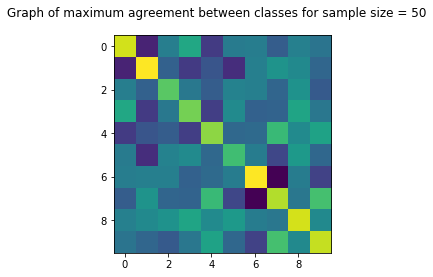

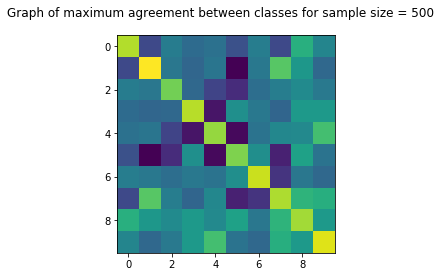

In [10]:
agg_to_disag50=cls_distinct(50,data)[3]
agg_to_disag500=cls_distinct(500,data)[3]
disag_show(50, agg_to_disag50)
disag_show(500, agg_to_disag500)

The ideal outcome would be a matrix in which the clear maximum of each row (or column, since the matrix is symmetric) occurs at the diagonal. 

In the above graph we can see for exampe that the second row, corresponding to the digit 1, has a good maximum at the column 2, but there also seems to be a big number in column 8, corresponding to the comparison of the digit 1 with the digit 7.

Here are the actual values of the matrix:

In [11]:
print(agg_to_disag50)

          0         1         2         3         4         5         6  \
0  0.938206  0.613541  0.741720  0.809434  0.642834  0.737135  0.740876   
1  0.613541  0.965523  0.697283  0.641232  0.678287  0.626209  0.743983   
2  0.741720  0.697283  0.865581  0.731825  0.690287  0.748137  0.744261   
3  0.809434  0.641232  0.731825  0.884398  0.647588  0.762272  0.696770   
4  0.642834  0.678287  0.690287  0.647588  0.899664  0.707294  0.710041   
5  0.737135  0.626209  0.748137  0.762272  0.707294  0.845591  0.739913   
6  0.740876  0.743983  0.744261  0.696770  0.710041  0.739913  0.965221   
7  0.689728  0.776330  0.703043  0.699321  0.840291  0.658217  0.575421   
8  0.744751  0.760685  0.774947  0.802940  0.762389  0.785844  0.739746   
9  0.725180  0.703446  0.686567  0.729771  0.799493  0.705218  0.652161   

          7         8         9  
0  0.689728  0.744751  0.725180  
1  0.776330  0.760685  0.703446  
2  0.703043  0.774947  0.686567  
3  0.699321  0.802940  0.729771  
4  0

In [8]:
print(agg_to_disag500)

          0         1         2         3         4         5         6  \
0  0.955870  0.773864  0.828962  0.809434  0.815618  0.781713  0.829996   
1  0.773864  0.987486  0.822302  0.803655  0.820230  0.713855  0.823315   
2  0.828962  0.822302  0.929719  0.806734  0.770484  0.748137  0.812399   
3  0.809434  0.803655  0.806734  0.958419  0.729274  0.850500  0.823357   
4  0.815618  0.820230  0.770484  0.729274  0.944264  0.721247  0.817796   
5  0.781713  0.713855  0.748137  0.850500  0.721247  0.934820  0.849137   
6  0.829996  0.823315  0.812399  0.823357  0.817796  0.849137  0.965663   
7  0.773897  0.916028  0.830036  0.803603  0.840291  0.739334  0.754562   
8  0.886074  0.858903  0.845189  0.861533  0.842368  0.870116  0.822614   
9  0.838127  0.805985  0.824625  0.861671  0.905591  0.818342  0.806333   

          7         8         9  
0  0.773897  0.886074  0.838127  
1  0.916028  0.858903  0.805985  
2  0.830036  0.845189  0.824625  
3  0.803603  0.861533  0.861671  
4  0

We see that when all samples of the digit 1 are compared with all other different samples, the maximum occurs at comparing 1 with 1 at 0.987486, and the next closer digit is a 7, with a maximum of 0.916028. 
This tells us that if we impose a threshold of 0.9, many samples of 7 would qualify to belong to the family of 1.

On the other hand, when we look at the digit 0, the maximum in comparing two different zeros is 0.955870, while the maximum of comparing any zero with any 8 is 0.886074. 

In ALL cases above, we see that the diagonal is biggest entry in each row, although not by much in some cases. 

It is interesting that the above matrix tells us that there are some 0s that look like 8s, some 1s that look like 7s, and some 4s that look like 9s.

# A rough testing method
It occurred to me that we could perhaps use the above matrix to implement a rudimentary classification test. The idea is to take a sample that is NOT in the above list, test it with respect to ALL our samples (literally, taking all our samples as the basis), and use the matrix above to decide what digit our sample likely is.

First, we write a function that computes the Frobenious product of the new sample with all the previous ones, and then computes the maximum product for eac class.

Then, we compare the entries for each digit with the rows of the matrix above, and decide what digit our sample could be.

## This method gives a 93.7% accuracy with the given database

In [9]:
#################################################################################################################
# This function computes "coordinates" of sample with respect to all members of the normalized basis 
# outputs only an array of the maximum attained coordinate for each given class
#################################################################################################################
def coord_Frob(sample,n_basis):
# Input: sample = any digit sample, 
#        n_basis = an array with all our chosen samples (basis), with an equal number N of 
#                consecutive samples for each of the C classes. The samples should be normalized to norm 1.
# Output: coord = array of C maximum agreement values between sample and elements of the basis, separated by class
#                 
    # N = number of samples in each class
    # C = number of classes
    N = int(np.size(n_basis[0]))
    C = int(np.size(n_basis)/N)
    
    # norm of the sample
    samplenorm=np.sqrt(np.sum(sample*sample))

    # compute norms of basis elements
    agree=[]
    for j in range(C):
        agrow=[]
        for v in n_basis[j]:
            agrow.append(np.sum(sample*v)/samplenorm)
        agree.append(agrow)
        
    # compute the maximum agreement between sample and basis for each digit
    
    coord=[]                   
    for j in range(C):
        coord.append(np.max(np.array(agree[j])))
            
    return np.array(coord)


#################################################################################################################
# This function normalizes a set of samples (basis). Simply divides each vector by its L2 norm.
#################################################################################################################
def n_the_basis(basis):
# takes a basis and normalizes its elements to norm 1
    # N = number of samples in each class
    # C = number of classes
    N = int(np.size(basis[0]))
    C = int(np.size(basis)/N)

    # compute norms of basis elements
    n_basis=[]
    for c in range(C):
        base=[]
        for j in range(N):
            basis[c][j]=basis[c][j]/np.sqrt(np.sum(basis[c][j]*basis[c][j]))
    
    return basis

#################################################################################################################
# This function implements a test based on the coordinates obtained from the basis.
# The resulting digit is simply the location of the biggest coordinate.
#################################################################################################################
def test_digit(sample,n_basis):
# compute coordinates of smaple with respect to the basis, and returns first digit with maximum agreement per class
#        n_basis = an array with all our chosen samples (basis), with an equal number N of 
#                consecutive samples for each of the C classes. The samples should be normalized to norm 1.
#     
    coord = coord_Frob(sample,n_basis)
    return np.argmax(coord)


#################################################################################################################
# This function displays an image of a sample for which the test has given an erroneous digit
# it also diaplays in the title which digit the test produced
#################################################################################################################
def dis_method_error(xc,j):
# Input: a DataFrame with three columns [c][j][d] where [c][j] idetifies the sample (digit = c) and d is
#        the digit that the test returned
    try:
        plt.imshow(data[xc.loc[j][0]][xc.loc[j][1]], cmap = 'gray')
        plt.suptitle('Method identifies this as a {}, but it is a {}'.format(xc.loc[j][2],xc.loc[j][0]))
        plt.show()
    except IndexError:
        print('{} is not a valid index. The error list only has {} entries.'.format(j,len(xc)))


#################################################################################################################
# This function returns a random list of indexes with T samples from each class
# The input is a list of how many samples each class has
# The function ignores the first 500 samples, which were used as a basis
#################################################################################################################
def sampling(dtalen,T):
# Input :    dtalen = list of number of samples in each data class
#                 T = number of random samples to take from each class
# Output: test_s_idx = list of arrays of T indexes from each class randomly chosen, 
#                     but avoiding the first 500 so no element of the "basis" are chosen
    test_s_len=(np.array(dtalen)-500)
    test_s_idx=[]
    for j in test_s_len:
        test_s_idx.append(np.random.choice(j, T, replace=False)+500) 
    return test_s_idx

#################################################################################################################
# This method takes a list of indexes and test the corresponding samples
# It returns a list of the samples for which the test gave an erroneous digit as an answer
# The output is t,s,xcep_sheet, where t is the total number of samples, 
# s is the total number of correct identifications, and xcep_sheet is an ordered list of the indexes
# for which the test gave the wrong digist
#################################################################################################################
def testing(test_s_idx):
    t=0
    s=0
    c=0
    xcep=[]
    for j in test_s_idx:
        for k in j:
            t+=1
            test=data[c][k]
            if test_digit(test,n_basis)==c:
                s+=1
            else:
                xcep.append([c,k,test_digit(test,n_basis)])
        c+=1
        xcep_sheet=pd.DataFrame(np.array(xcep))
    print('{} correct out of {}. {}% accuracy'.format(s,t,100*s/t))
    return t,s,xcep_sheet.sort_values(by=[0, 1],ignore_index=True)

First, we collect the data and the number of samples of each class into a list dtalen.

In [10]:
data = [extract_image(images, i) for i in range(10)]
dtalen = display_lengths(data)

6903 examples of digit 0
7877 examples of digit 1
6990 examples of digit 2
7141 examples of digit 3
6824 examples of digit 4
6313 examples of digit 5
6876 examples of digit 6
7293 examples of digit 7
6825 examples of digit 8
6958 examples of digit 9
70000 examples in total



Now we extract the first 500 samples from each class. This will be our *basis*. We *normalize* them into a list called n_basis using the function n_the_basis.

In [11]:
samples=[]
for j in range(10):
    samples.append(data[j][:500])
n_basis=n_the_basis(samples)

Suppose we want to check what digit our method believes is in entry "data[8][3210]". The answer should be **8**.

In [12]:
test_digit(data[8][3210],n_basis)

8

This is promosing, we got the right digit identified. However, if we try enough digits eventually we find an error.

In [13]:
test_digit(data[8][3024],n_basis)

3

We should have gotten 8 as an answer, but we got a 3. We wonder how close that digit looks like an 8?
We can check the image:

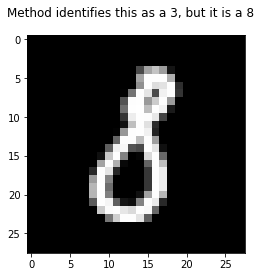

In [14]:
plt.imshow(data[8][3024], cmap = 'gray')
plt.suptitle('Method identifies this as a {}, but it is a {}'.format(3,8))
plt.show()

To estimate the actual accuracy of our method, we must select randomly a big number of samples and test them.

We choose 1000 random samples from each class (not in the basis).

In [15]:
test_s_idx=sampling(dtalen,1000)

Now we run the test on each one of the randomly sampled digits. The *testing* function returns the total number of samples tested *t*, the total number of positively identified samples *s*, and a DataFrame with the samples that were incorrectly identified, together with what digit the test gave.

In [16]:
t,s,xcep_sheet=testing(test_s_idx)
print(xcep_sheet)

9389 correct out of 10000. 93.89% accuracy
     0     1  2
0    0   605  2
1    0  1368  6
2    0  2739  9
3    0  3218  9
4    0  3344  8
..  ..   ... ..
606  9  6412  7
607  9  6460  4
608  9  6707  3
609  9  6732  4
610  9  6879  4

[611 rows x 3 columns]


According to this testing sample the accuracy of the test is **93.7%**. Not bad for a start. This is indeed pretty close to the accuracy of the method if we test ALL the samples.

The DataFrame *xcep_sheet* containing all the errors can be used to finding ways to improve the method.

For example, we can display a few of the errors using the function *dis_method_error*.

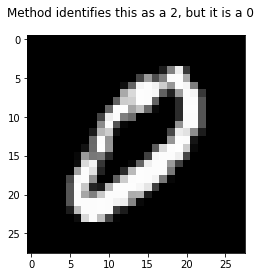

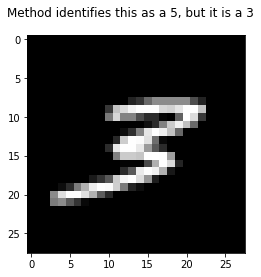

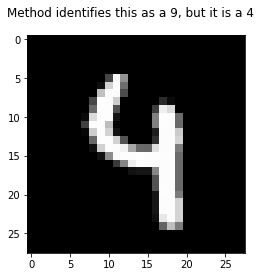

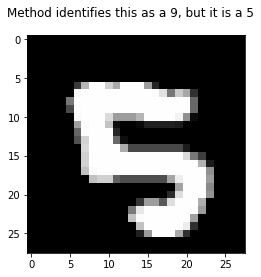

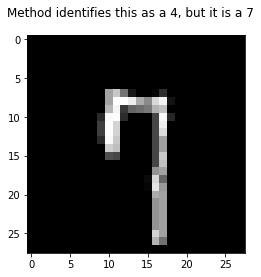

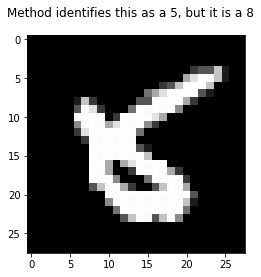

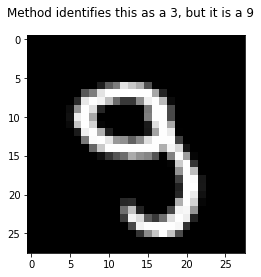

In [17]:
dis_method_error(xcep_sheet,0)
dis_method_error(xcep_sheet,100)
dis_method_error(xcep_sheet,200)
dis_method_error(xcep_sheet,300)
dis_method_error(xcep_sheet,400)
dis_method_error(xcep_sheet,500)
dis_method_error(xcep_sheet,600)